# [Advanced] Nano particle energy

本章は発展編の位置付けとします。次章へ急ぎたい方はスキップし、後から読んでいただいても構いません。

本章では、Nano particle (クラスター構造) の過剰エネルギー(excess energy)計算と、担体上の吸着構造作成を行ってみます。

In [1]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfcc_extras.visualize.view import view_ngl


print(f"pfp_api_client: {pfp_api_client.__version__}")

# estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="latest")
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v2.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.3.1


In [4]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase import Atoms 
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
from ase.io import Trajectory
import numpy as np
import pandas as pd

## 過剰エネルギー - Excess energy

純金属に1種類以上他の元素を混ぜた材料を<b>合金 (alloy)</b>と呼びますが、
金属は2種類以上の元素を組み合わせることで、その性質を大きく変化させるようなものがあります。

例えば、アルミニウムと銅やマグネシウムを混ぜた、[ジュラルミン](https://ja.wikipedia.org/wiki/%E3%82%B8%E3%83%A5%E3%83%A9%E3%83%AB%E3%83%9F%E3%83%B3)はその軽くて硬い性質から航空宇宙機器などに使われています。

2種類の元素が混ざったものを2元系合金、3種類以上の元素が混ざったものは多元系合金と呼ばれます。

多元系合金は、新たな性質を持つような材料の発見も期待されていますが、
元素の種類が増えるほどその組成比の組み合わせが大きくなり、まだまだ解析が進んでいない領域です。<br/>
このような系も[Matlantis](https://matlantis.com)ではその汎用性を活かし、扱うことができます。


こういった合金の原子構造を考える際には、現実ではどのように混ざるのか、そもそもきれいに混ざることができる組み合わせなのかを知る必要があります。

このような合金の安定度合いを測る指標として、過剰エネルギー(excess energy)があります。<br/>
元素Aと元素Bを混ぜた2元系合金 (alloy)の過剰エネルギー(excess energy)は以下のように計算され、その合金のエネルギーが、元素A, Bがそれぞれ混ざっていなかった場合と比べてどのくらい安定かを示します。

$$ E_{\rm{excess}} = \frac{1}{N_{\rm{alloy}}} \left( E_{\rm{alloy}} - \frac{N_{\rm{alloyA}}}{N_{\rm{alloy}}} E_{\rm{A}} - \frac{N_{\rm{alloyB}}}{N_{\rm{alloy}}} E_{\rm{B}} \right) $$

$E_{\rm{alloy}}$が合金のエネルギー、$E_\rm{A}, E_\rm{B}$ は単原子AまたはBで構成された時のエネルギーで、$N_{\rm{alloy}}, N_{\rm{alloyA}}, N_{\rm{alloyB}}$はそれぞれ合金のすべての原子数、元素Aの原子数、元素Bの原子数です。

多元系の場合も同様に定義できます。

ここでは、PtとPdを混ぜた構造に対して、excess energyを評価することでその安定性を評価してみましょう。

参考文献:

 - [Electronic Structure and Phase Stability of PdPt Nanoparticles](https://pubs.acs.org/doi/10.1021/acs.jpclett.5b02753)
 - [Electronic structure and phase stability of Pt3M (M = Co, Ni, and Cu) bimetallic nanoparticles](https://www.sciencedirect.com/science/article/abs/pii/S0927025620303657)
 - [Calculations of Real-System Nanoparticles Using Universal Neural Network Potential PFP](https://arxiv.org/abs/2107.00963)

Pt711 Nano particleに対して、Pdを混ぜた構造に対して、
2元系のNano particleを考えた場合にもその混ざり方は様々な可能性が考えられます。

今回は以下のような構造を作成し、そのexcess energyを評価してみます。
 - PtとPdが均等に混ざる形で存在する構造
 - Ptが内殻に、Pdが外殻に存在する構造
 - Pdが内殻に、Ptが外殻に存在する構造

Core shell構造を作成する関数定義です。読み飛ばしていただいて構いません。

In [2]:
from typing import List, Tuple

from ase import Atoms, neighborlist
from ase.cluster import Cluster
import numpy as np
from ase.data import atomic_numbers


def cluster2atoms(cluster: Cluster) -> Atoms:
    """Convert ASE Cluster to ASE Atoms

    Args:
        cluster (Cluster): input cluster instance

    Returns:
        atoms (Atoms): converted output, atoms instance
    """
    return Atoms(cluster.symbols, cluster.positions, cell=cluster.cell)


def calc_coordination_numbers(atoms: Atoms) -> Tuple[List[int], List[np.ndarray]]:
    """Calculates coordination number

    Args:
        atoms: input atoms

    Returns:
        cns (list): coordination number for each atom
        bonds (list): bond destination indices for each atom
    """
    nl = neighborlist.NeighborList(
        neighborlist.natural_cutoffs(atoms), self_interaction=False, bothways=True
    )
    nl.update(atoms)
    bonds = []
    cns = []
    for i, _ in enumerate(atoms):
        indices, offsets = nl.get_neighbors(i)
        bonds.append(indices)
        cns.append(len(indices))
    return cns, bonds


def substitute(scaffold: Atoms, sites: np.ndarray, elements: List[str]) -> Atoms:
    """Substibute `elements` to `sites` indices of `scaffold` atoms

    Args:
        scaffold (Atoms): Original input atoms
        sites (np.ndarray): site indices to substitute `elements`
        elements (list): elements to be substituted

    Returns:
        substituted (Atoms): substituted ase atoms
    """
    substituted = scaffold.copy()
    for site, element in zip(sites, elements):
        substituted.numbers[site] = atomic_numbers[element]
    return substituted


def make_core_shell(scaffold: Atoms, element: str) -> Atoms:
    """Make core shell structure

    Input `scaffold` element is kept inside core shell,
    and outside surface is replaced by `element`.

    Note that it is not fully tested.
    It was not guaranteed to work on all the cases.

    Args:
        scaffold (Atoms): input cluster structure
        element (str): outside surface element to be replaced

    Returns:
        coreshell (Atoms): core shell structure
    """
    # CN : vertex < edge < surface < core
    cn = np.array(calc_coordination_numbers(scaffold)[0])
    cn_set = np.unique(cn)
    vertexes = None
    surfaces = None
    cores = None
    if len(cn_set) == 1:
        pass
    elif len(cn_set) == 2:
        cores = np.where(cn == cn_set[1])[0]
        surfaces = np.where(cn == cn_set[0])[0]
    elif len(cn_set) == 3 or len(cn_set) == 4:
        cores = np.where(cn == cn_set[-1])[0]
        surfaces = np.where(cn != cn_set[-1])[0]
        vertexes = np.where(cn == cn_set[0])[0]
    else:
        cores = np.where(cn == cn_set[-1])[0]
        surfaces = np.where(cn != cn_set[-1])[0]
        vertexes = np.where(np.isin(cn, cn_set[:-3]))[0]

    if surfaces is None:
        core_shell = scaffold.copy()
    else:
        core_shell = substitute(scaffold, surfaces, [element] * len(surfaces))
    return core_shell


まず今回ベースとなるNano particle 骨格構造(scaffold)を作成します。

In [5]:
Pt711 = cluster2atoms(Octahedron("Pt", 11, cutoff=4))
view_ngl(Pt711)

`make_core_shell` 関数を用いて、ベース骨格の内殻のみ "Pd" 元素に置き換えた構造 Pd306Pt405構造を作成します。

In [6]:
Pd306Pt405 = make_core_shell(Pt711, "Pd")
view_ngl(Pd306Pt405)

同様にして、外殻がPd, 内殻がPtとなる構造Pd405Pt306を作成します。

In [7]:
Pd711 = Octahedron("Pd", 11, cutoff=4)
Pd405Pt306 = make_core_shell(Pd711, "Pt")
view_ngl(Pd405Pt306)

In [8]:
symbols, counts = np.unique(Pd405Pt306.symbols, return_counts=True)
print(f"Pd405Pt306 structure contains {symbols} with counts {counts}", )

symbols, counts = np.unique(Pd306Pt405.symbols, return_counts=True)
print(f"Pd306Pt405 structure contains {symbols} with counts {counts}", )

Pd405Pt306 structure contains ['Pd' 'Pt'] with counts [405 306]
Pd306Pt405 structure contains ['Pd' 'Pt'] with counts [306 405]


ここで得られたそれぞれの構造を構造緩和し、エネルギーを求めます。

In [9]:
from ase.optimize import FIRE

def get_opt_energy(atoms, fmax=0.001):    
    opt = FIRE(atoms)
    opt.run(fmax=fmax)
    return atoms.get_total_energy()

In [10]:
print("Optimizing Pt711")
Pt711.calc = calculator
E_pt711 = get_opt_energy(Pt711)

print("Optimizing Pd306Pt405")
Pd306Pt405.calc = calculator
E_pd306pt405 = get_opt_energy(Pd306Pt405)

print("Optimizing Pd405Pt306")
Pd405Pt306.calc = calculator
E_pd405pt306 = get_opt_energy(Pd405Pt306)

print("Optimizing Pd711")
Pd711.calc = calculator
E_pd711 = get_opt_energy(Pd711)

Optimizing Pt711
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 21:48:32    -3606.102285*       0.9110
FIRE:    1 21:48:33    -3606.865790*       0.8629
FIRE:    2 21:48:33    -3608.121073*       0.7681
FIRE:    3 21:48:33    -3609.316469*       0.6533
FIRE:    4 21:48:33    -3610.297430*       0.5368
FIRE:    5 21:48:33    -3611.136663*       0.4232
FIRE:    6 21:48:33    -3611.885560*       0.3152
FIRE:    7 21:48:34    -3612.556241*       0.3143
FIRE:    8 21:48:34    -3613.147630*       0.2875
FIRE:    9 21:48:34    -3613.654483*       0.2383
FIRE:   10 21:48:34    -3614.078352*       0.1688
FIRE:   11 21:48:34    -3614.431057*       0.1769
FIRE:   12 21:48:35    -3614.728201*       0.1871
FIRE:   13 21:48:35    -3614.981377*       0.1713
FIRE:   14 21:48:35    -3615.192996*       0.1451
FIRE:   15 21:48:35    -3615.360896*       0.1064
FIRE:   16 21:48:35    -3615.482822*       0.0878
FIRE:   17 21:48:35    -3615.564295

それぞれのエネルギーが得られたので、ここからexcess energyを計算することができます。

In [11]:
E_exess_pd306pt405 = (E_pd306pt405 - 306 / 711 * E_pd711 - 405 / 711 * E_pt711) / 711
E_exess_pd405pt306 = (E_pd405pt306 - 405 / 711 * E_pd711 - 306 / 711 * E_pt711) / 711

print(f"Excess energy of Pd306Pt405 = {E_exess_pd306pt405 * 1000:.2f} meV")
print(f"Excess energy of Pd405Pt306 = {E_exess_pd405pt306 * 1000:.2f} meV")

Excess energy of Pd306Pt405 = -43.99 meV
Excess energy of Pd405Pt306 = 6.09 meV


Excess energyが負となっているPd306Pt405は単独でPd, Pt nano particleが存在するよりも混合したほうが安定であるということを示唆しています。<br/>
一方で正となっているPd405Pt306の構造はPd306Pt405と比べると不安定であることになります。

この結果から、**PdとPtの合金微粒子では、Pdが外殻に来るような構造が自然界では安定して存在しそう**だという考察ができます。

最後に、Pt306個、Pd405個がランダムに配置されたような構造のexcess energyを求めてみましょう。

In [12]:
Pd405Pt306_random = Pt711.copy()
# randomly choose 405 atoms to be replaced to Pd
pd_indices = np.random.choice(np.arange(711), 405, replace=False)
Pd405Pt306_random.numbers[pd_indices] = atomic_numbers["Pd"]

print(f"Replaced to Pd with indices {pd_indices}")
view_ngl(Pd405Pt306_random)

Replaced to Pd with indices [652 657 363 485 309 188   9 333 704 122 600 710 642 294 685 571 470 278
 402 166 537 298 421  29  83 367 591 607 695  65 500 193 106 560 280 207
 303 644  24 461 471 214 674  78  28  79 551 307 117 409 290 589 524 450
 434 486 590 203  93 419  53  35 563  43 382 137 445 475 632  16 250 483
 541 319 584 572 324  44 634 476 221  30 348 408 631 709 379 366 533 233
  50 526 390 480 599 128 257 301 677 243 597 416 261 136  11 187 413  85
 239 621 364 354 102 352 116 399  27 418 329  10 115 263 435 543  76 655
 545 215 336 698 238 430  63 218 463 103 316 624   2 135 613  97 146 225
 235 283 469 694 598 232 267 561  32 312 433 164 105  98 183 466 335 481
 345 330  60 665 568 299 282 148 190 596 237 443  89 328 498  14 227 623
 369 111  25 100 455 630 265 423  37 605 706 251 268 373 609  17 636 109
 699 691 260 611 398 242 275 557 649 184 244 446 191 515 458  41  18 121
 502 675  86   4 507 236 570 223 229 610 180 161 606 532 130 284 647 264
 241 410 546 479 403  2

In [13]:
print("Optimizing Pd405Pt306_random")
Pd405Pt306_random.calc = calculator
E_pd405pt306_random = get_opt_energy(Pd405Pt306_random)

Optimizing Pd405Pt306_random
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 21:49:23    -2950.187405*       0.8687
FIRE:    1 21:49:23    -2950.643686*       0.8310
FIRE:    2 21:49:23    -2951.433609*       0.7527
FIRE:    3 21:49:23    -2952.356431*       0.6270
FIRE:    4 21:49:23    -2953.113809*       0.4732
FIRE:    5 21:49:24    -2953.679682*       0.3261
FIRE:    6 21:49:24    -2954.101570*       0.3327
FIRE:    7 21:49:24    -2954.420094*       0.2938
FIRE:    8 21:49:24    -2954.662627*       0.2436
FIRE:    9 21:49:24    -2954.840300*       0.2691
FIRE:   10 21:49:24    -2954.961254*       0.2784
FIRE:   11 21:49:25    -2955.044162*       0.2627
FIRE:   12 21:49:25    -2955.114441*       0.2009
FIRE:   13 21:49:25    -2955.186543*       0.2072
FIRE:   14 21:49:25    -2955.257837*       0.2118
FIRE:   15 21:49:25    -2955.321873*       0.1743
FIRE:   16 21:49:26    -2955.374468*       0.1670
FIRE:   17 21:49:26    

In [14]:
view_ngl(Pd405Pt306_random)

In [15]:
E_exess_pd405pt306_random = (E_pd405pt306_random - 405 / 711 * E_pd711 - 306 / 711 * E_pt711) / 711

print(f"Excess energy of Pd306Pt405 random = {E_exess_pd405pt306_random * 1000:.2f} meV")

Excess energy of Pd306Pt405 random = -27.78 meV


この場合も負のexcess energyが得られ、この構造が安定になりうるという結果が得られました。

今回は完全にランダムな配置を行って構造を作成しましたが、実際は物質が混ざる場合には局所的にパターンを取ることでより安定な構造となる可能性もあります。
こういった分析を進める場合はモンテカルロ法を用いて配置パターンを最適化するということがよく行われますがここでは省略します。<br/>
（モンテカルロ法の説明及びその実例については将来後述されるかもしれません。）

このように、様々な構造を作成し、そのexcess energyを計算することで合金の安定構造がどのようになるかを解析する事ができます。

## 担体上への微粒子吸着構造作成



本チュートリアルでは、担体上に微粒子をおいたモデリングの簡単な計算事例を紹介するにとどめ、この構造の現実での妥当性検証までは行いません。

ここでは、担持貴金属担体としてSnO2を、Nano particleとしてはPt を用いて、担体上へPt Nano particleを乗せた構造を作成してみます。

 - [The effect of SnO2(110) supports on the geometrical and electronic properties of platinum nanoparticles](https://link.springer.com/article/10.1007/s42452-019-1478-0)
 - [Calculations of Real-System Nanoparticles Using Universal Neural Network Potential PFP](https://arxiv.org/abs/2107.00963)

In [16]:
# bulk, support material
from ase.io import read
SnO2 = read("../input/SnO2_mp-856_conventional_standard.cif")
view_ngl(SnO2, representations=["ball+stick"])

ここではSlab構造の作成(Bulkからの特定ミラー面の切り出し)にpymatgenの `SlabGenerator` を用いています。<br/>
これは`SlabGenerator` のinstance化をする際の初期化パラメータとして作りたいSlab構造のパラメータを指定し、<br/>
`get_slabs` 関数を呼ぶことで指定された初期化パラメータにマッチするSlab構造が列挙されて得られます。

 - [pymatgen document](https://pymatgen.org/pymatgen.core.surface.html#pymatgen.core.surface.SlabGenerator)

詳しくは、以下のMaterials Project Workshopでも紹介されています。

 - [Working with Surfaces and Interfaces - The Materials Project Workshop](https://workshop.materialsproject.org/lessons/03_heterointerfaces/Main%20Lesson/)

In [17]:
# Generate slab
from ase.build import make_supercell
import numpy as np
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor


slab_gen = SlabGenerator(
    initial_structure=AseAtomsAdaptor.get_structure(SnO2),
    miller_index=[1,1,0],
    min_slab_size=5.0, # ここで層の出方が変わる
    min_vacuum_size=15.0, # nanoparticleを載せるので大きめに
    lll_reduce=False,
    center_slab=True,
    primitive=True,
    max_normal_search=1,
)
slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)

得られた `slabs` はpymatgenのinstanceです。これは、`AseAtomsAdaptor` を用いてASEのAtoms instanceに変換することができます。

得られた構造をASE Atomsに変換して、可視化してみます。

In [18]:
slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
view_ngl(slab_atoms_list, representations=["ball+stick"])

２つの構造が得られました。

以降では2つ目の構造を使用して、Slabを作成していきます。

ASEでsupercellを作成した後、

In [19]:
slab = slab_atoms_list[1].copy()

# make supercell: expand to xy-plane
#slab = make_supercell(slab, [[4, 0, 0], [0, 2, 0], [0, 0, 1]])  # this is same with below.
slab = slab * (4, 2, 1)

# shift `slab` to bottom of cell
min_pos_z = np.min(slab.positions, axis=0)[2]
slab.set_positions(slab.positions - [0, 0, min_pos_z])

In [20]:
view_ngl(slab, representations=["ball+stick"], replace_structure=True)

担体のSlab構造を作成することができました。

次にこの担体上に乗せるNano particle clusterを作成します。

In [21]:
Pt55 = Octahedron("Pt", 5, cutoff=2)

# cut cluster to make half-sphere
cluster = Pt55.copy()
# Rotate cluster to make triangle surface comes to top.
cluster.rotate([0, 0, 1], [1, 1, 1], center=cluster.get_center_of_mass())
# Cut bottom 2 layers
for _ in range(2):
    target = np.round(cluster.positions, decimals=0)
    del cluster[np.where(target[:,2]==np.min(target[:,2]))[0]]

In [22]:
view_ngl(cluster, representations=["ball+stick"])

Nano particle clusterを担体の上に乗せましょう。

ここでは、プログラムを書いて担体真ん中の上にNano particleを乗せていますが、
5章で紹介する`SurfaceEditor`を用いると、InteractiveにNano particleを移動させて初期構造を作成することも可能です。

In [23]:
from ase.data import atomic_numbers, chemical_symbols, covalent_radii


# Put Pt37 on top of SnO2. Both perpendincular lines goes z-axis.
slab_xy_size = np.min(slab.cell.cellpar()[0:2])
cluster_xy_size = np.max(
    (np.max(cluster.positions, axis=0) - np.min(cluster.positions, axis=0))[0:2]
)
# Vacuum size
min_slab_xy_size = cluster_xy_size + 15
for i in range(1, 5):
    print(f"i={i}")
    if slab_xy_size * i < min_slab_xy_size:
        pass
    else:
        slab_sc = make_supercell(slab, [[i, 0, 0], [0, i, 0], [0, 0, 1]])
        break
slab_surface_xy_center = np.append(
    slab_sc.cell.cellpar()[0:2] / 2, np.max(slab_sc.positions, axis=0)[2]
)
cluster_surface_xy_center = np.append(
    np.mean(cluster.positions, axis=0)[0:2], np.min(cluster.positions, axis=0)[2]
)
cluster = Atoms(cluster.get_chemical_symbols(), cluster.positions - cluster_surface_xy_center)
slab_surface_covalent_radii = covalent_radii[
    slab_sc.get_atomic_numbers()[np.argmax(slab_sc.positions, axis=0)[2]]
]
cluster_surface_covalent_radii = covalent_radii[
    cluster.get_atomic_numbers()[np.argmin(cluster.positions, axis=0)[2]]
]
cluster.translate(
    slab_surface_xy_center + [0, 0, slab_surface_covalent_radii + cluster_surface_covalent_radii]
)
supported = slab_sc.copy()
supported += cluster

i=1
i=2


In [24]:
view_ngl(supported, representations=["ball+stick"])

In [25]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from ase.optimize import BFGS, LBFGS, FIRE
from ase.io import Trajectory
print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(model_version="v2.0.0")
calculator = ASECalculator(estimator)
supported.calc = calculator
traj = Trajectory("./SnO2_Pt119.traj", "w", supported)
opt = FIRE(supported)
opt.attach(traj.write, interval=1)
opt.run(fmax=0.005)
traj.close()

pfp_api_client: 1.3.1
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 21:49:55    -1855.847009*       2.8403
FIRE:    1 21:49:55    -1862.111119*       2.4214
FIRE:    2 21:49:55    -1867.469367*       2.0034
FIRE:    3 21:49:55    -1871.902342*       1.9501
FIRE:    4 21:49:56    -1875.412249*       1.8872
FIRE:    5 21:49:56    -1878.078114*       1.8113
FIRE:    6 21:49:56    -1880.058562*       1.7186
FIRE:    7 21:49:56    -1881.576496*       1.6046
FIRE:    8 21:49:56    -1882.918589*       1.4662
FIRE:    9 21:49:56    -1884.337971*       1.3873
FIRE:   10 21:49:56    -1885.949107*       1.2718
FIRE:   11 21:49:56    -1887.699174*       1.0725
FIRE:   12 21:49:57    -1889.416201*       0.9923
FIRE:   13 21:49:57    -1890.921991*       0.9958
FIRE:   14 21:49:57    -1892.131598*       0.9771
FIRE:   15 21:49:57    -1893.088740*       0.9342
FIRE:   16 21:49:57    -1893.931135*       0.8694
FIRE:   17 21:49:57    -1894.7

In [26]:
SnO2_Pt119 = Trajectory("./SnO2_Pt119.traj")
view_ngl(SnO2_Pt119, representations=["ball+stick"])

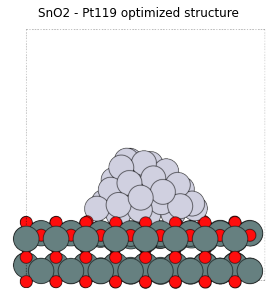

In [27]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


write("output/sno2_pt119_opt.png", SnO2_Pt119[-1], rotation="-90x,0y,0z")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mpimg.imread("output/sno2_pt119_opt.png"))
ax.set_axis_off()
ax.set_title("SnO2 - Pt119 optimized structure")
fig.show()

論文で示されているようなchargeの可視化も可能です。

Nano particleの吸着面に近いところでのみ電荷が０からずれていて、核の外側がプラスに、内側がマイナスになっていることが確認できます。

In [28]:
v = view_ngl(SnO2_Pt119[-1], show_charge=True)
v.show_charge_label()
v

このように、SnO2担体上にPt Nano particleが吸着している構造を作成することができました。

実際には、本当にこの構造で正しいのか（微粒子の状態で吸着するのか、それとも全体に均質に伸びて吸着するような形のほうが安定なのかなど)の検証が必要となりますが、このTutorialでは省略します。

こういった構造が作成できる事により、ここから更に後述する反応探索やMDなどを組み合わせることで、

 - 様々な面が露出している触媒下での反応
 - 触媒と担体の境界面での反応

なども扱えるようになる可能性があり、より現実に近い状態での触媒反応シミュレーションができる可能性があります。

参考文献

 - [Calculations of Real-System Nanoparticles Using Universal Neural Network Potential PFP](https://arxiv.org/abs/2107.00963)
 - [Structural Stability of Ruthenium Nanoparticles: A Density Functional Theory Study](https://pubs.acs.org/doi/10.1021/acs.jpcc.7b08672)
 - [Electronic Structure and Phase Stability of PdPt Nanoparticles](https://pubs.acs.org/doi/10.1021/acs.jpclett.5b02753)
 - [Electronic structure and phase stability of Pt3M (M = Co, Ni, and Cu) bimetallic nanoparticles](https://www.sciencedirect.com/science/article/abs/pii/S0927025620303657)
 - [The effect of SnO2(110) supports on the geometrical and electronic properties of platinum nanoparticles](https://link.springer.com/article/10.1007/s42452-019-1478-0)